In [4]:
library(maps)  # making making 
library(mapproj)  # projections for map making
library(spgwr)  # spatially-weighted regression
library(rpart)  # tree-structured modeling
library(randomForest)  # random forests
library(rpart.plot)  # plot tree-structured model information
library(lattice)  # statistical graphics
library(cvTools)  # cross-validation tools including rmspe 

Loading required package: robustbase


In [5]:
# read in the housing data
houses <-  read.table("data/houses_data.txt", header = FALSE, sep = "", 
   dec = ".", row.names = NULL, 
   col.names = c("value", "income", "age", "rooms", "bedrooms", 
   "pop", "hh", "latitude", "longitude"))   

In [6]:
# computed variables for linear model used by Pace and Barry (1997)   
houses$log_value <- log(houses$value)  
houses$income_squared <- houses$income^2 
houses$income_cubed <- houses$income^3 
houses$log_age <- log(houses$age)
houses$log_pc_rooms <- log(houses$rooms / houses$pop)
houses$log_pc_bedrooms <- log(houses$bedrooms / houses$pop)
houses$log_pop_hh <- log(houses$pop / houses$hh)
houses$log_hh <- log(houses$hh)

In [7]:
# structure of the Pace and Barry (1997) model for baseline for comparisons
pace.barry.model <- {log_value ~ income + income_squared + 
  income_cubed + log_age + log_pc_rooms + log_pc_bedrooms + 
  log_pop_hh + log_hh}

# for comparison let's look at a simple model with the original variables
simple.model <-  {log_value ~ income + age + rooms + bedrooms +
  pop + hh} 
  
# original variables plus variables that add value for trees 
# that is... variables that are not simple monotonic transformations
# of the original explanatory variables
full.model <- {log_value ~ income + age + rooms + bedrooms +
  pop + hh + log_pc_rooms + log_pc_bedrooms + log_pop_hh}  
  
# define variable for selecting a geographically defined
# subset of the data... San Diego area  
# we use nested ifelse statements to do this

# define the bounding box for selecting the area
# here we are selecting the San Diego region
BB.TOP <- 33
BB.BOTTOM <- 32
BB.RIGHT <- -116.75
BB.LEFT <- -125

In [8]:
houses$select <- ifelse(((houses$latitude < BB.TOP)),
  ifelse((houses$longitude < BB.RIGHT),
  ifelse((houses$latitude > BB.BOTTOM),
  ifelse((houses$longitude > BB.LEFT),1,2),2),2),2)
houses$select <- factor(houses$select, levels = c(1,2), 
  labels = c("Selected","Not Selected"))
houses.selected <- subset(houses, subset = (select == "Selected"))
houses.notselected <- subset(houses, subset = (select == "Not Selected"))  
    

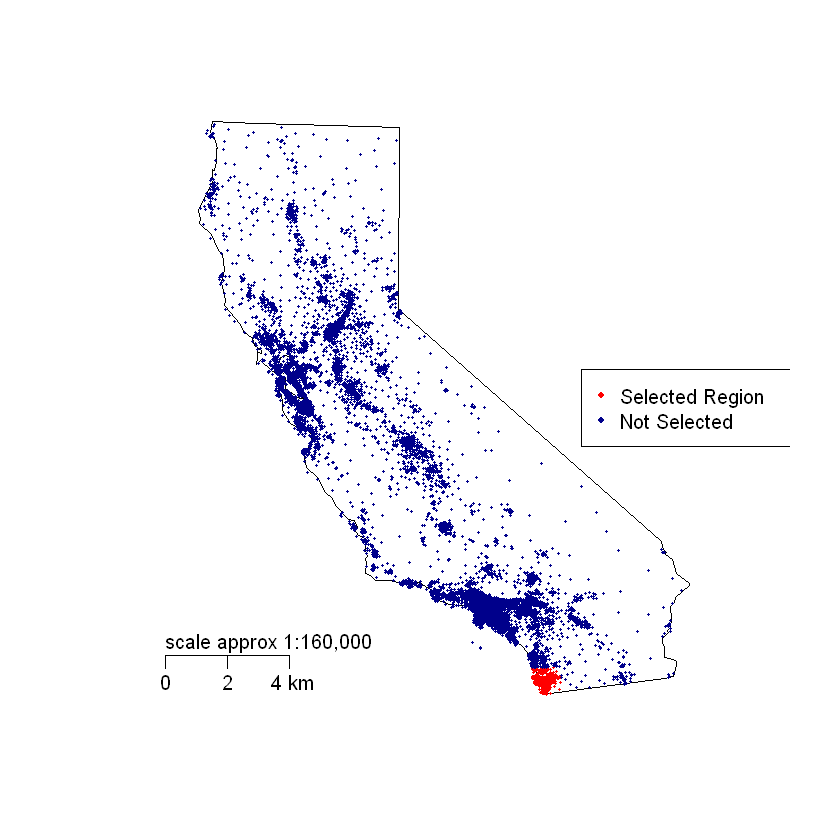

In [9]:
# plot the locations of block groups red in the selected area, blue otherwise
#pdf(file = "fig_spatial_map_selected_region.pdf", width = 8.5, height = 8.5)
pointsize <- 0.5
map("state", region = c("california"), project="albers",par=c(39,45)) 
  points(mapproject(houses.selected$longitude, houses.selected$latitude,
  projection=""),pch=20,cex=pointsize,col="red")
  points(mapproject(houses.notselected$longitude, houses.notselected$latitude,
  projection=""),pch=20,cex=pointsize,col="darkblue")
legend("right", legend = c("Selected Region","Not Selected"), 
  col = c("red","darkblue"), pch = 20)
map.scale()  
#dev.off()

In [10]:
# define training and test sets for the selected houses
set.seed(4444)
partition <- sample(nrow(houses.selected)) # permuted list of row index numbers
houses.selected$Group <- 
  ifelse((partition < nrow(houses.selected)/(3/2)),1,2)
houses.selected$Group <- 
  factor(houses.selected$Group,levels=c(1,2),labels=c("TRAIN","TEST"))
print(table(houses.selected$Group))  # review the split into training and test
print(head(houses.selected))  # review the selected data

houses.train <- 
  subset(houses.selected, subset = (Group == "TRAIN"))
houses.test <- 
  subset(houses.selected, subset = (Group == "TEST")) 
  
# examine the correlations across the variables before we begin modeling
houses.train.df.vars <- houses.train[,c("log_value","income","age",
  "rooms","bedrooms","pop","hh","log_pc_rooms",
  "log_pc_bedrooms","log_pop_hh")]
  


TRAIN  TEST 
  803   403 
       value income age rooms bedrooms pop  hh latitude longitude log_value
14006 441700 4.7396  52  2023      301 649 285    32.76   -117.18  12.99839
14007 408500 5.3920  52  1539      212 535 224    32.75   -117.18  12.92025
14008 459600 8.6030  52  1504      208 518 196    32.75   -117.18  13.03811
14009 500001 8.1548  52  1495      230 459 190    32.75   -117.19  13.12237
14010 411600 6.1309  52  1388      213 513 211    32.75   -117.19  12.92781
14011 500001 5.7914  52  1294      175 434 180    32.76   -117.19  13.12237
      income_squared income_cubed  log_age log_pc_rooms log_pc_bedrooms
14006       22.46381     106.4695 3.951244    1.1369041      -0.7683225
14007       29.07366     156.7652 3.951244    1.0566214      -0.9256805
14008       74.01161     636.7219 3.951244    1.0659083      -0.9124372
14009       66.50076     542.3004 3.951244    1.1808313      -0.6909709
14010       37.58793     230.4479 3.951244    0.9953433      -0.8789837
14011    

In [11]:
houses.train.cormat <- cor(as.matrix(houses.train.df.vars))
houses.train.cormat.line <- houses.train.cormat["log_value",]
# explanatory variables ordered by correlation with the response variable
ordered.houses.train.cormat <- 
  houses.train.cormat[names(sort(houses.train.cormat.line,decreasing=TRUE)),
  names(sort(houses.train.cormat.line,decreasing=FALSE))]

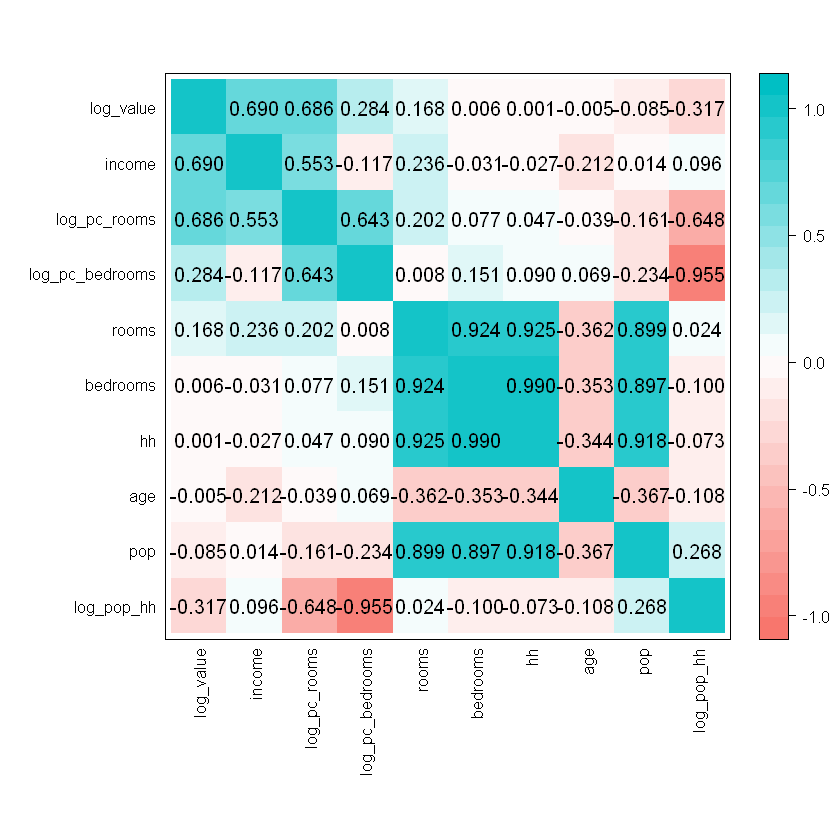

In [12]:
# code to obtain default colors from ggplot2...
number.of.default.colors <- 2  # two end-points for our scale
end.point.colors <- hcl(h=seq(15, 375-360/number.of.default.colors,
  length=number.of.default.colors)%%360, c=100, l=65)
# end.point.colors[1] and [2] used to define the three-point color scale

# pdf(file = "fig_spatial_correlation_heat_map.pdf", width = 11, 
#  height = 8.5)
x <- rep(1:nrow(ordered.houses.train.cormat),
  times=ncol(ordered.houses.train.cormat))
y <- NULL
for (i in 1:ncol(ordered.houses.train.cormat)) 
  y <- c(y,rep(i,times=nrow(ordered.houses.train.cormat)))
# use fixed format 0.XXX in cells of correlation matrix
cortext <- sprintf("%0.3f", as.numeric(ordered.houses.train.cormat))  
text.data.frame <- data.frame(x, y, cortext)
text.data.frame$cortext <- as.character(text.data.frame$cortext)
text.data.frame$cortext <- ifelse((text.data.frame$cortext == "1.000"),
    NA,text.data.frame$cortext)  # define diagonal cells as missing
text.data.frame <- na.omit(text.data.frame)  # diagonal cells have no text

print(levelplot(ordered.houses.train.cormat, cuts = 25, tick.number = 9,
  col.regions = 
    colorRampPalette(c(end.point.colors[1], "white", end.point.colors[2])),
  scales=list(tck=0, x=list(rot=90)),
  xlab = "", 
  ylab = "",
  panel = function(...) {
    panel.levelplot(...)  
    panel.text(text.data.frame$x, text.data.frame$y, 
    labels = text.data.frame$cortext)
    }))
#dev.off()    

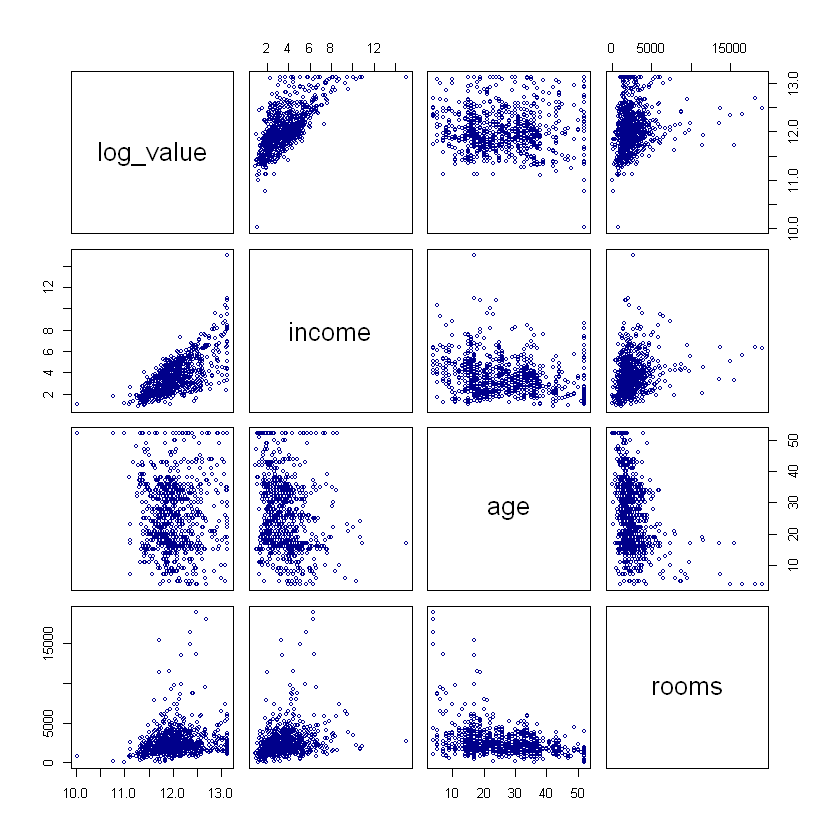

In [13]:
# scatter plot matrix (splom) demonstration
houses.train.splom.vars <- 
  houses.train[,c("log_value","income","age","rooms")]
# pdf(file = "fig_spatial_sample_splom.pdf", width = 8.5, 
#  height = 8.5)
pairs(houses.train.splom.vars, cex = 0.65, col = "darkblue")
#dev.off()

In [14]:
# define spatial objects as needed for spatial modeling work 
# explanation of spatial objects may be found in chapter 2 of
# Bivand, R. S., Pebesma, E. J., and Gomez-Rubio, V. (2008) 
# Applied Spatial Data Analysis, New York: Springer.
# this involves adding coordinate objects to data frame objects
# training set coordinates to add
houses.coord <- cbind(houses.train$longitude,houses.train$latitude) 
# define spatial points data frame object
houses.train <- SpatialPointsDataFrame(houses.coord,houses.train,bbox = NULL) 

# test set coordinates to add
houses.coord <- cbind(houses.test$longitude,houses.test$latitude) 
# define spatial points data frame object
houses.test <- SpatialPointsDataFrame(houses.coord,houses.test,bbox = NULL) 

# examine the struction of the spatial points data frame
print(str(houses.train))  

Formal class 'SpatialPointsDataFrame' [package "sp"] with 5 slots
  ..@ data       :'data.frame':	803 obs. of  19 variables:
  .. ..$ value          : num [1:803] 408500 459600 500001 411600 500001 ...
  .. ..$ income         : num [1:803] 5.39 8.6 8.15 6.13 5.79 ...
  .. ..$ age            : num [1:803] 52 52 52 52 52 36 23 49 52 21 ...
  .. ..$ rooms          : num [1:803] 1539 1504 1495 1388 1294 ...
  .. ..$ bedrooms       : num [1:803] 212 208 230 213 175 534 594 494 262 486 ...
  .. ..$ pop            : num [1:803] 535 518 459 513 434 ...
  .. ..$ hh             : num [1:803] 224 196 190 211 180 531 536 419 249 482 ...
  .. ..$ latitude       : num [1:803] 32.8 32.8 32.8 32.8 32.8 ...
  .. ..$ longitude      : num [1:803] -117 -117 -117 -117 -117 ...
  .. ..$ log_value      : num [1:803] 12.9 13 13.1 12.9 13.1 ...
  .. ..$ income_squared : num [1:803] 29.1 74 66.5 37.6 33.5 ...
  .. ..$ income_cubed   : num [1:803] 157 637 542 230 194 ...
  .. ..$ log_age        : num [1:803] 3.9

In [15]:
# --------------------------------------------
# Linear regression a la Pace and Barry (1997)
# --------------------------------------------
pace.barry.train.fit <- lm(pace.barry.model, data = houses.train)

print(pace.barry.train.fit)
print(summary(pace.barry.train.fit))

# direct calculation of root-mean-squared prediction error 
# obtained directly on the training data
print(rmspe(houses.train$log_value, predict(pace.barry.train.fit))) 
# report R-squared on training data
print(cor(houses.train$log_value,predict(pace.barry.train.fit))^2)

cat("\n\nTraining set proportion of variance accounted",
  " for by linear regression = ",
  sprintf("%1.3f",cor(houses.train$log_value,
  predict(pace.barry.train.fit))^2),sep=" ")

# test model fit to training set on the test set
print(rmspe(houses.test$log_value, predict(pace.barry.train.fit, 
  newdata = houses.test))) 
print(cor(houses.test$log_value,
  predict(pace.barry.train.fit, newdata = houses.test))^2)
  
cat("\n\nTest set proportion of variance accounted",
  " for by linear regression = ",
  sprintf("%1.3f",cor(houses.test$log_value,
  predict(pace.barry.train.fit, newdata = houses.test))^2),sep=" ")  
  
# demonstrate cross-validation within the training set
# specify ten-fold cross-validation within the training set
# K = folds   R = replications of K-fold cross-validation
set.seed(1234)  # for reproducibility
folds <- cvFolds(nrow(houses.train), K = 10, R = 50)  
cv.pace.barry.train.fit <- cvLm(pace.barry.train.fit, cost = rtmspe, 
  folds = folds, trim = 0.1)
# root-mean-squared prediction error estimated by cross-validation
print(cv.pace.barry.train.fit)


Call:
lm(formula = pace.barry.model, data = houses.train)

Coefficients:
    (Intercept)           income   income_squared     income_cubed  
      11.328534         0.109107         0.017346        -0.001131  
        log_age     log_pc_rooms  log_pc_bedrooms       log_pop_hh  
       0.105285         0.141457        -0.028180        -0.546219  
         log_hh  
       0.038683  


Call:
lm(formula = pace.barry.model, data = houses.train)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.41721 -0.16599 -0.02227  0.13766  1.03596 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)     11.3285340  0.1714460  66.076  < 2e-16 ***
income           0.1091066  0.0468096   2.331  0.02001 *  
income_squared   0.0173457  0.0077151   2.248  0.02483 *  
income_cubed    -0.0011315  0.0003904  -2.898  0.00386 ** 
log_age          0.1052854  0.0208900   5.040 5.77e-07 ***
log_pc_rooms     0.1414570  0.0777626   1.819  0.06927 .  
log_pc_bedrooms -0.028

Call:
rpart(formula = simple.model, data = houses.train)
  n= 803 

          CP nsplit rel error    xerror       xstd
1 0.29410366      0 1.0000000 1.0019589 0.05631528
2 0.14976880      1 0.7058963 0.7170898 0.04570448
3 0.02706349      2 0.5561275 0.5737357 0.03610174
4 0.02349265      3 0.5290640 0.5737048 0.03691744
5 0.01741974      5 0.4820787 0.5386605 0.03596446
6 0.01324194      9 0.4123998 0.5217198 0.03429556
7 0.01000000     10 0.3991578 0.5177536 0.03469061

Variable importance
  income      age      pop    rooms bedrooms       hh 
      69        7        7        6        5        5 

Node number 1: 803 observations,    complexity param=0.2941037
  mean=12.05081, MSE=0.192623 
  left son=2 (696 obs) right son=3 (107 obs)
  Primary splits:
      income   < 5.32885 to the left,  improve=0.29410370, (0 missing)
      rooms    < 1024    to the left,  improve=0.06578183, (0 missing)
      pop      < 1183.5  to the right, improve=0.04183966, (0 missing)
      bedrooms < 77.5 

[1] 0.277285
[1] 0.6008422


Training set proportion of variance accounted  for by tree-structured regression =  0.601[1] 0.3478524
[1] 0.4037499


Test set proportion of variance accounted  for by tree-structured regression =  0.404cex 0.948   xlim c(0, 1)   ylim c(0, 1)


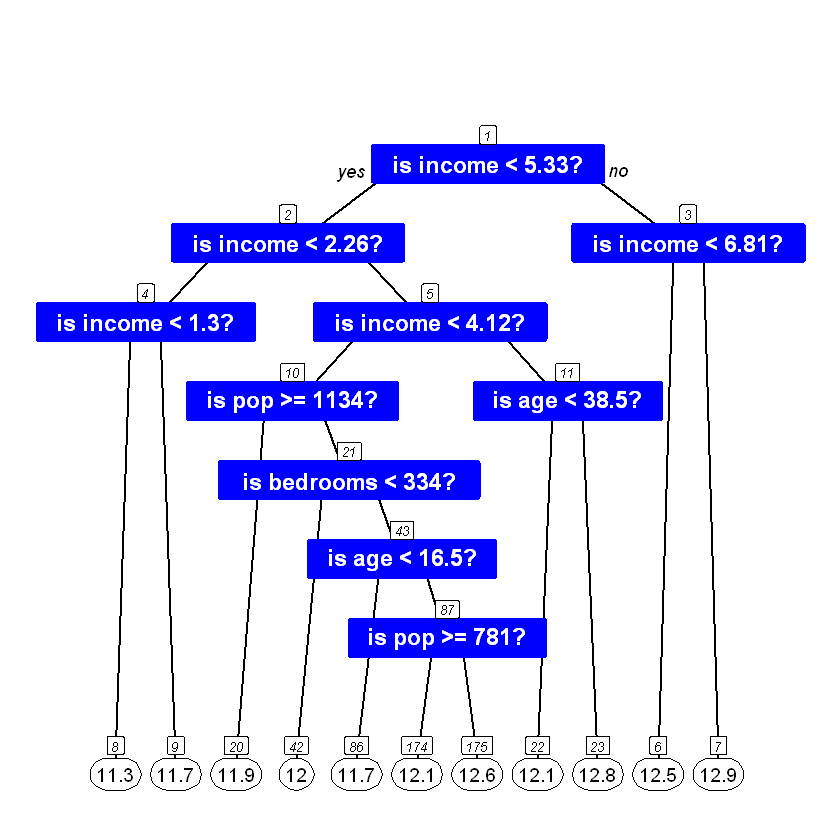

In [16]:
# --------------------------------------
# Tree-structured regression (simple)
# --------------------------------------
# try tree-structured regression on the original explantory variables
# note that one of the advantages of trees is no need for transformations
# of the explanatory variables 
rpart.train.fit <- rpart(simple.model, data = houses.train)
print(summary(rpart.train.fit))  # tree summary statistics and split detail
houses.train$rpart.train.fit.pred <- predict(rpart.train.fit, 
  data = houses.train)

# root-mean-squared for trees on training set
print(rmspe(houses.train$log_value, houses.train$rpart.train.fit.pred)) 
# report R-squared on training data
print(cor(houses.train$log_value,houses.train$rpart.train.fit.pred)^2)

cat("\n\nTraining set proportion of variance accounted",
  " for by tree-structured regression = ",
  sprintf("%1.3f",cor(houses.train$log_value,
  houses.train$rpart.train.fit.pred)^2),sep=" ")

# root-mean-squared for trees on test set
houses.test$rpart.train.fit.pred <- predict(rpart.train.fit, newdata = houses.test)
print(rmspe(houses.test$log_value, houses.test$rpart.train.fit.pred)) 
# report R-squared on training data
print(cor(houses.test$log_value,houses.test$rpart.train.fit.pred)^2)

cat("\n\nTest set proportion of variance accounted",
  " for by tree-structured regression = ",
  sprintf("%1.3f",
  cor(houses.test$log_value,houses.test$rpart.train.fit.pred)^2),sep=" ")

# plot the regression tree result from rpart
#pdf(file = "fig_spatial_rpart_model.pdf", width = 8.5, height = 8.5)
prp(rpart.train.fit, main="",
  digits = 3,  # digits to display in terminal nodes
  nn = TRUE,  # display the node numbers
  fallen.leaves = TRUE,  # put the leaves on the bottom of the page
  branch = 0.5,  # change angle of branch lines
  branch.lwd = 2,  # width of branch lines
  faclen = 0,  # do not abbreviate factor levels
  trace = 1,  # print the automatically calculated cex
  shadow.col = 0,  # no shadows under the leaves
  branch.lty = 1,  # draw branches using dotted lines
  split.cex = 1.2,  # make the split text larger than the node text
  split.prefix = "is ",  # put "is " before split text
  split.suffix = "?",  # put "?" after split text
  split.box.col = "blue",  # lightgray split boxes (default is white)
  split.col = "white",  # color of text in split box 
  split.border.col = "blue",  # darkgray border on split boxes
  split.round = .25)  # round the split box corners a tad
#dev.off()


Call:
rpart(formula = full.model, data = houses.train)
  n= 803 

           CP nsplit rel error    xerror       xstd
1  0.36957978      0 1.0000000 1.0018854 0.05623900
2  0.09253626      1 0.6304202 0.6584266 0.04000090
3  0.07954998      2 0.5378840 0.5860452 0.03564882
4  0.03441113      3 0.4583340 0.5015991 0.03371739
5  0.02944949      4 0.4239228 0.4951772 0.03375549
6  0.01801253      5 0.3944734 0.4654073 0.03219833
7  0.01597595      6 0.3764608 0.4325397 0.03064742
8  0.01159800      8 0.3445089 0.4223959 0.02909689
9  0.01052854      9 0.3329109 0.4020443 0.02743957
10 0.01000000     10 0.3223824 0.3911207 0.02648231

Variable importance
   log_pc_rooms          income      log_pop_hh log_pc_bedrooms             age 
             42              26              12              10               4 
            pop           rooms        bedrooms              hh 
              3               2               1               1 

Node number 1: 803 observations,    complexity p

[1] 0.2491952
[1] 0.6776176


Training set proportion of variance accounted  for by tree-structured regression (full model) =  0.678[1] 0.2924421
[1] 0.5736942


Test set proportion of variance accounted  for by tree-structured regression (full model) =  0.574cex 0.788   xlim c(0, 1)   ylim c(0, 1)


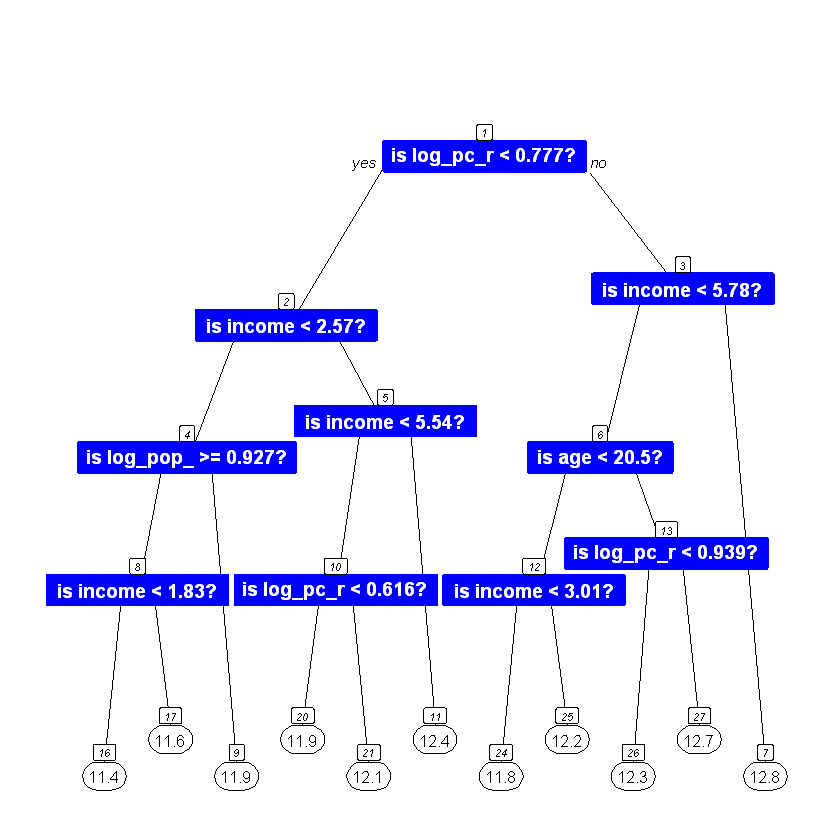

In [17]:
# --------------------------------------
# Tree-structured regression (full)
# --------------------------------------
# try tree-structured regression on the expanded set of variables 
rpart.train.fit.full <- rpart(full.model, data = houses.train)
print(summary(rpart.train.fit.full))  # tree summary statistics and split detail
houses.train$rpart.train.fit.full.pred <- 
  predict(rpart.train.fit.full, data = houses.train)

# root-mean-squared for trees on training set
print(rmspe(houses.train$log_value, houses.train$rpart.train.fit.full.pred)) 
# report R-squared on training data
print(cor(houses.train$log_value,houses.train$rpart.train.fit.full.pred)^2)

cat("\n\nTraining set proportion of variance accounted",
   " for by tree-structured regression (full model) = ",
  sprintf("%1.3f",cor(houses.train$log_value,
  houses.train$rpart.train.fit.full.pred)^2),sep=" ")

# root-mean-squared for trees on test set
houses.test$rpart.train.fit.full.pred <- predict(rpart.train.fit.full, 
  newdata = houses.test)
print(rmspe(houses.test$log_value, houses.test$rpart.train.fit.full.pred)) 
# report R-squared on training data
print(cor(houses.test$log_value,houses.test$rpart.train.fit.full.pred)^2)

cat("\n\nTest set proportion of variance accounted",
    " for by tree-structured regression (full model) = ",
  sprintf("%1.3f",cor(houses.test$log_value,
  houses.test$rpart.train.fit.full.pred)^2),sep=" ")

# plot the regression tree result from rpart
#pdf(file = "fig_spatial_rpart_model_full.pdf", width = 8.5, height = 8.5)
prp(rpart.train.fit.full, main="",
  digits = 3,  # digits to display in terminal nodes
  nn = TRUE,  # display the node numbers
  fallen.leaves = TRUE,  # put the leaves on the bottom of the page
  branch = 0.5,  # change angle of branch lines
  branch.lwd = 2,  # width of branch lines
  faclen = 0,  # do not abbreviate factor levels
  trace = 1,  # print the automatically calculated cex
  shadow.col = 0,  # no shadows under the leaves
  branch.lty = 1,  # draw branches using dotted lines
  split.cex = 1.2,  # make the split text larger than the node text
  split.prefix = "is ",  # put "is" before split text
  split.suffix = "?",  # put "?" after split text
  split.box.col = "blue",  # lightgray split boxes (default is white)
  split.col = "white",  # color of text in split box 
  split.border.col = "blue",  # darkgray border on split boxes
  split.round = .25)  # round the split box corners a tad
#dev.off()


Call:
 randomForest(formula = simple.model, data = houses.train, mtry = 3,      importance = TRUE, na.action = na.omit) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 3

          Mean of squared residuals: 0.06991898
                    % Var explained: 63.7
[1] 0.1146651
[1] 0.9452182


Training set proportion of variance accounted for by random forests (simple model) =  0.945[1] 0.2942473
[1] 0.5646507


Test set proportion of variance accounted  for by random forests (simple model) =  0.565

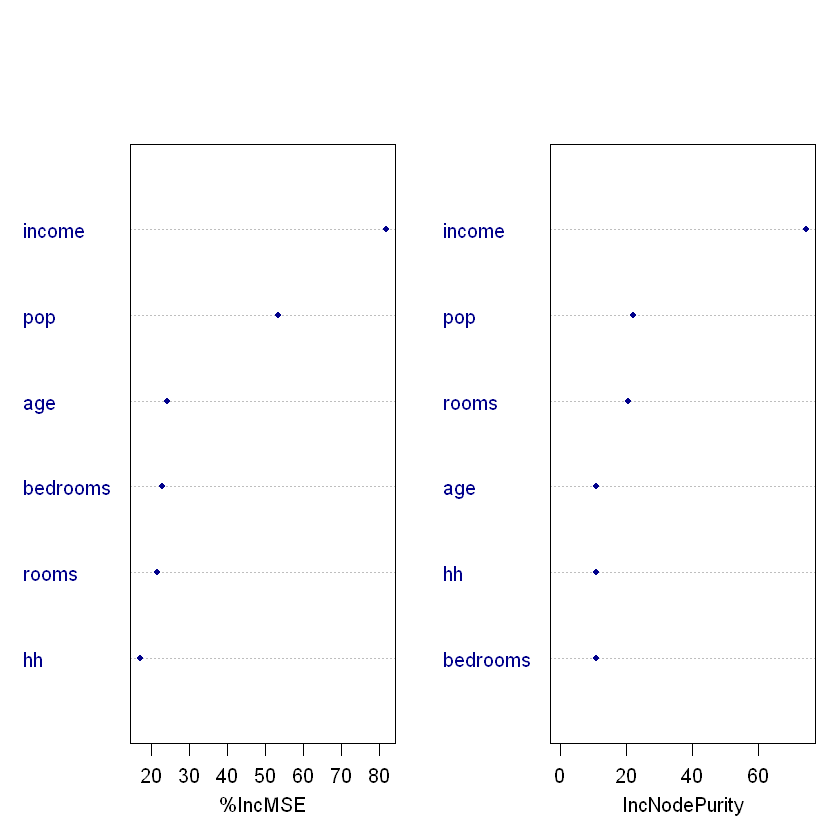

In [23]:
# --------------------------------------
# Random forests (simple)
# --------------------------------------
set.seed (9999)  # for reproducibility
rf.train.fit <- randomForest(simple.model, 
  data=houses.train, mtry=3, importance=TRUE, na.action=na.omit) 

# review the random forest solution      
print(rf.train.fit)  

# check importance of the individual explanatory variables 
# pdf(file = "fig_spatial_random_forest_simple_importance.pdf", 
# width = 11, height = 8.5)
varImpPlot(rf.train.fit, main = "", pch = 20, col = "darkblue")
#dev.off()

# random forest predictions for the training set
houses.train$rf.train.fit.pred <- predict(rf.train.fit, type="class", 
  newdata = houses.train)

# root-mean-squared for random forest on training set
print(rmspe(houses.train$log_value, houses.train$rf.train.fit.pred)) 
# report R-squared on training data
print(cor(houses.train$log_value,houses.train$rf.train.fit.pred)^2)

cat("\n\nTraining set proportion of variance accounted",
    "for by random forests (simple model) = ",
  sprintf("%1.3f",
  cor(houses.train$log_value,houses.train$rf.train.fit.pred)^2),sep=" ")
    
# random forest predictions for the test set using model from training set
houses.test$rf.train.fit.pred <- predict(rf.train.fit, 
  type="class", newdata = houses.test)

# root-mean-squared for random forest on test set
print(rmspe(houses.test$log_value, houses.test$rf.train.fit.pred)) 
# report R-squared on training data
print(cor(houses.test$log_value,houses.test$rf.train.fit.pred)^2)

cat("\n\nTest set proportion of variance accounted",
    " for by random forests (simple model) = ",
  sprintf("%1.3f",
  cor(houses.test$log_value,houses.test$rf.train.fit.pred)^2),sep=" ")



Call:
 randomForest(formula = full.model, data = houses.train, mtry = 3,      importance = TRUE, na.action = na.omit) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 3

          Mean of squared residuals: 0.06328609
                    % Var explained: 67.15
[1] 0.1092729
[1] 0.9486865


Training set proportion of variance accounted  for by random forests (full model) =  0.949[1] 0.263197
[1] 0.6511199


Test set proportion of variance accounted  for by random forests (full model) =  0.651

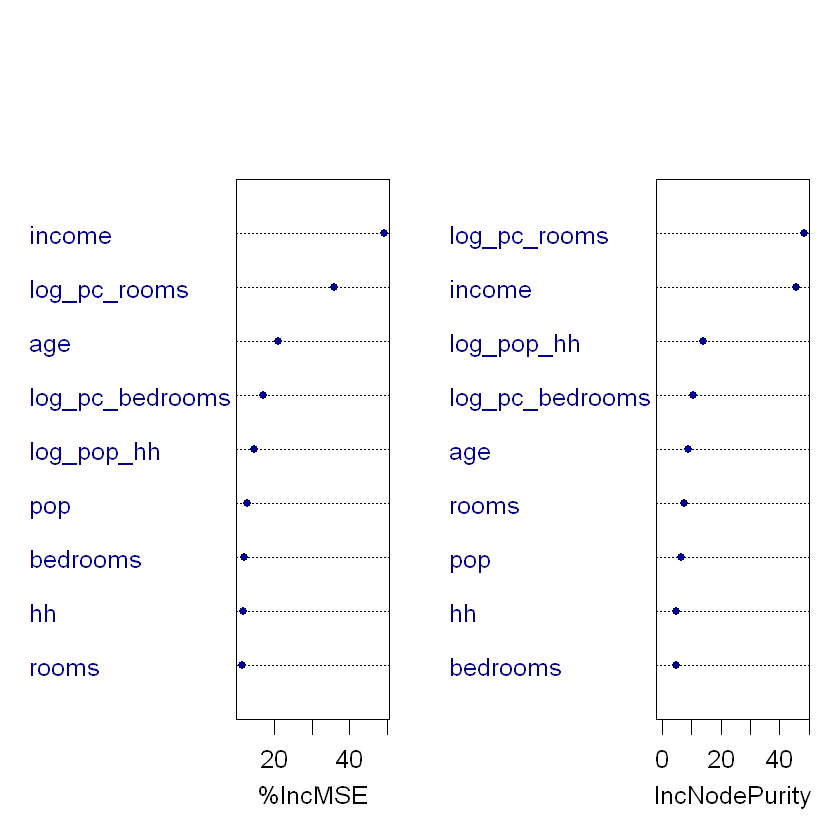

In [24]:
# --------------------------------------
# Random forests (full)
# --------------------------------------
set.seed (9999)  # for reproducibility
rf.train.fit.full <- randomForest(full.model, 
  data=houses.train, mtry=3, importance=TRUE, na.action=na.omit) 

# review the random forest solution      
print(rf.train.fit.full)  

# check importance of the individual explanatory variables 
#pdf(file = "fig_spatial_random_forest_full_importance.pdf", 
#width = 11, height = 8.5)
varImpPlot(rf.train.fit.full, main = "", pch = 20, 
  cex = 1.25, col = "darkblue", lcolor = "black")
#dev.off()

# random forest predictions for the training set
houses.train$rf.train.fit.full.pred <- predict(rf.train.fit.full, type="class", 
  newdata = houses.train)

# root-mean-squared for random forest on training set
print(rmspe(houses.train$log_value, houses.train$rf.train.fit.full.pred)) 
# report R-squared on training data
print(cor(houses.train$log_value,houses.train$rf.train.fit.full.pred)^2)

cat("\n\nTraining set proportion of variance accounted",
    " for by random forests (full model) = ",
  sprintf("%1.3f",cor(houses.train$log_value,
    houses.train$rf.train.fit.full.pred)^2),sep=" ")
    
# random forest predictions for the test set using model from training set
houses.test$rf.train.fit.full.pred <- predict(rf.train.fit.full, type="class", 
  newdata = houses.test)

# root-mean-squared for random forest on test set
print(rmspe(houses.test$log_value, houses.test$rf.train.fit.full.pred)) 
# report R-squared on training data
print(cor(houses.test$log_value,houses.test$rf.train.fit.full.pred)^2)

cat("\n\nTest set proportion of variance accounted",
    " for by random forests (full model) = ",
  sprintf("%1.3f",cor(houses.test$log_value,
    houses.test$rf.train.fit.full.pred)^2),sep=" ")

In [20]:
# --------------------------------------
# Geographically weighted regression
# --------------------------------------    
# bandwidth calculation may take a while
set.bandwidth <-  gwr.sel(pace.barry.model, 
  data=houses.train, verbose = FALSE, show.error.messages = FALSE) 

# fit the geographically-weighted regression with bandwidth value set.bandwidth
gwr.train.fit <- gwr(pace.barry.model, bandwidth = set.bandwidth, 
  predictions = TRUE, data=houses.train, fit.points = houses.train)
# extract training set predictions
houses.train$grw.train.fit.pred <- gwr.train.fit$SDF$pred  

# root-mean-squared for grw on training set
print(rmspe(houses.train$log_value, houses.train$grw.train.fit.pred)) 
# report R-squared on training data
print(cor(houses.train$log_value,houses.train$grw.train.fit.pred)^2)

cat("\n\nTraining set proportion of variance accounted",
  " for by geographically-weighted regression = ",
  sprintf("%1.3f",cor(houses.train$log_value,
  houses.train$grw.train.fit.pred)^2),sep=" ")

# fit the geographically-weighted regression with bandwidth value set.bandwidth
# fit to training data and specify test data
gwr.train.fit <- gwr(pace.barry.model, bandwidth = set.bandwidth, 
  predictions = TRUE, data=houses.train, fit.points = houses.test)
# extract test set predictions
houses.test$grw.train.fit.pred <- gwr.train.fit$SDF$pred  

# root-mean-squared for grw on test set
print(rmspe(houses.test$log_value, houses.test$grw.train.fit.pred)) 
# report R-squared on training data
print(cor(houses.test$log_value,houses.test$grw.train.fit.pred)^2)

cat("\n\nTest set proportion of variance accounted",
  " for by geographically-weighted regression = ",
  sprintf("%1.3f",cor(houses.test$log_value,
  houses.test$grw.train.fit.pred)^2),sep=" ")

[1] 0.2343306
[1] 0.715599


Training set proportion of variance accounted  for by geographically-weighted regression =  0.716[1] 0.273895
[1] 0.6265548


Test set proportion of variance accounted  for by geographically-weighted regression =  0.627

In [21]:
# --------------------------------------
# Gather results for a single report
# --------------------------------------     
# measurement model performance summary
methods <- c("Linear regression Pace and Barry (1997)",
  "Tree-structured regression (simple model)",
  "Tree-structured regression (full model)",
  "Random forests (simple model)",
  "Random forests (full model)",
  "Geographically weighted regression (GWR)")
methods.performance.data.frame <- data.frame(methods)

methods.performance.data.frame$training <- 
  c(round(cor(houses.train$log_value,predict(pace.barry.train.fit))^2
    ,digits=3),
    round(cor(houses.train$log_value,
    houses.train$rpart.train.fit.pred)^2,digits=3),
    round(cor(houses.train$log_value,
    houses.train$rpart.train.fit.full.pred)^2,digits=3),
    round(cor(houses.train$log_value,
    houses.train$rf.train.fit.pred)^2,digits=3),
     round(cor(houses.train$log_value,
     houses.train$rf.train.fit.full.pred)^2,digits=3),
    round(cor(houses.train$log_value,
    houses.train$grw.train.fit.pred)^2,digits=3))
  
methods.performance.data.frame$test <-
  c(round(cor(houses.test$log_value,
  predict(pace.barry.train.fit, newdata = houses.test))^2,digits=3),
    round(cor(houses.test$log_value,
    houses.test$rpart.train.fit.pred)^2,digits=3),
    round(cor(houses.test$log_value,
    houses.test$rpart.train.fit.full.pred)^2,digits=3),
    round(cor(houses.test$log_value,
    houses.test$rf.train.fit.pred)^2,digits=3),
    round(cor(houses.test$log_value,
    houses.test$rf.train.fit.full.pred)^2,digits=3),
    round(cor(houses.test$log_value,
    houses.test$grw.train.fit.pred)^2,digits=3))

print(methods.performance.data.frame)

                                    methods training  test
1   Linear regression Pace and Barry (1997)    0.648 0.562
2 Tree-structured regression (simple model)    0.601 0.404
3   Tree-structured regression (full model)    0.678 0.574
4             Random forests (simple model)    0.945 0.565
5               Random forests (full model)    0.949 0.651
6  Geographically weighted regression (GWR)    0.716 0.627
